In [1]:
# 分析时间：2013年1月1日-2022年12月31日，总共10年时间
# 但是在做特征分析的时候，可以把数据拉长。多搞一年：即2012-01-01至2022-12-31
feature_start_date_str = "2011-01-01"
start_date_str = "2012-01-01"
end_date_str = "2022-12-31"

In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import QuantLib as ql
%matplotlib inline

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [3]:
def clean_data(raw_df, date_benchmark, feature_start_date, end_date):
    clean_df = raw_df[(raw_df['Date']>=feature_start_date) & (raw_df['Date']<=end_date)].reset_index(drop=True)
    investment_fac_df = pd.merge(date_benchmark, clean_df, on="Date", how="left")
    # 采用向下填充
    clean_df = clean_df.fillna(method='ffill')
    return clean_df

def plot_features(clean_df, col_name_list, title="Investment in fixed assets completed"):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for temp_col in col_name_list:
        ax.plot(clean_df['Date'], clean_df[temp_col], label=temp_col)
        

    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.legend(loc=2)
    plt.show()

In [4]:
feature_start_date = datetime.datetime.strptime(feature_start_date_str, "%Y-%m-%d")
start_date = datetime.datetime.strptime(start_date_str, "%Y-%m-%d")
end_date = datetime.datetime.strptime(end_date_str, "%Y-%m-%d")
print(feature_start_date, start_date, end_date)

2011-01-01 00:00:00 2012-01-01 00:00:00 2022-12-31 00:00:00


In [5]:
# 取出目标数据
# 到期收益率
raw_yield_to_maturity_df = pd.read_excel('./data/国债到期收益率.xlsx')
raw_yield_to_maturity_df = raw_yield_to_maturity_df.rename(columns={'指标名称': 'Date',
       '国债到期收益率:6个月': "6M", '国债到期收益率:1年': "1Y", '国债到期收益率:2年': "2Y", '国债到期收益率:3年': "3Y",
       '国债到期收益率:4年': "4Y", '国债到期收益率:5年': "5Y", '国债到期收益率:6年': "6Y", '国债到期收益率:7年': "7Y", 
        '国债到期收益率:8年': "8Y",'国债到期收益率:9年': "9Y", '国债到期收益率:10年': "10Y", '国债到期收益率:15年': "15Y", 
        '国债到期收益率:20年': "20Y", '国债到期收益率:30年': "30Y"})
raw_yield_to_maturity_df

,Date,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,30Y
0,2008-07-01,3.2769,3.4474,3.8065,4.0301,4.1697,4.3093,4.3498,4.3903,4.4292,4.4682,4.5072,4.9618,4.9639,4.9498
1,2008-07-02,3.4055,3.5461,3.8015,3.9506,4.0883,4.2260,4.3019,4.3778,4.4282,4.4787,4.5291,4.9442,4.9462,4.9501
2,2008-07-03,3.3343,3.4972,3.8687,3.9820,4.1085,4.2350,4.3163,4.3976,4.4436,4.4896,4.5356,4.9453,4.9469,4.9501
3,2008-07-04,3.3397,3.4763,3.8179,3.9854,4.1031,4.2209,4.3183,4.4157,4.4618,4.5080,4.5542,4.9469,4.9479,4.9501
4,2008-07-07,3.3679,3.4796,3.8138,3.9561,4.0850,4.2140,4.2849,4.3559,4.4215,4.4871,4.5527,4.9226,4.9285,4.9404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,2023-03-13,2.1958,2.2696,2.4373,2.5289,2.6127,2.6965,2.7655,2.8345,2.8473,2.8600,2.8728,3.0310,3.1147,3.2772
3668,2023-03-14,2.1950,2.2655,2.4475,2.5215,2.6046,2.6877,2.7591,2.8305,2.8417,2.8528,2.8640,3.0196,3.1047,3.2692
3669,2023-03-15,2.2050,2.2638,2.4432,2.5278,2.6121,2.6963,2.7663,2.8363,2.8474,2.8584,2.8695,3.0152,3.1033,3.2700
3670,2023-03-16,2.1799,2.2598,2.4193,2.5182,2.5953,2.6723,2.7483,2.8242,2.8342,2.8441,2.8541,2.9998,3.0857,3.2503


In [6]:
# 按特征长度选择数据
yield_to_maturity_df = raw_yield_to_maturity_df[(raw_yield_to_maturity_df['Date']>=feature_start_date)
                                                & (raw_yield_to_maturity_df['Date']<=end_date)].reset_index(drop=True)
yield_to_maturity_df

,Date,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,30Y
0,2011-01-04,2.9635,3.0310,3.3571,3.3839,3.4591,3.5343,3.6066,3.6790,3.7370,3.7951,3.8531,4.0629,4.1640,4.2839
1,2011-01-05,2.9262,3.0047,3.1834,3.2891,3.3696,3.4500,3.5466,3.6432,3.6993,3.7553,3.8113,4.0108,4.1683,4.2554
2,2011-01-06,2.6401,2.8361,3.1205,3.2438,3.3567,3.4696,3.5691,3.6686,3.7146,3.7607,3.8067,4.0104,4.1645,4.2528
3,2011-01-07,2.6055,2.7599,3.1324,3.3165,3.3916,3.4667,3.5586,3.6505,3.7163,3.7820,3.8478,4.0208,4.1638,4.2649
4,2011-01-10,2.5607,2.7767,3.0750,3.2557,3.3469,3.4381,3.5293,3.6205,3.6891,3.7578,3.8264,4.0104,4.1569,4.2575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,2022-12-26,2.1778,2.2398,2.3669,2.4616,2.5396,2.6175,2.7175,2.8175,2.8249,2.8324,2.8398,2.9777,3.0579,3.2225
2989,2022-12-27,2.2125,2.2615,2.3889,2.4898,2.5777,2.6656,2.7526,2.8395,2.8475,2.8556,2.8636,3.0014,3.0676,3.2182
2990,2022-12-28,2.2398,2.2732,2.4056,2.4746,2.5771,2.6795,2.7595,2.8395,2.8496,2.8598,2.8699,3.0078,3.0679,3.2125
2991,2022-12-29,2.1737,2.1952,2.3605,2.4405,2.5415,2.6425,2.7314,2.8202,2.8255,2.8309,2.8362,2.9741,3.0459,3.2021


In [7]:
date_benchmark = yield_to_maturity_df[["Date"]]
date_benchmark

,Date
0,2011-01-04
1,2011-01-05
2,2011-01-06
3,2011-01-07
4,2011-01-10
...,...
2988,2022-12-26
2989,2022-12-27
2990,2022-12-28
2991,2022-12-29


In [8]:
## CPI

raw_cpi_df = pd.read_excel("./data/features/CPI.xlsx")
raw_cpi_df = raw_cpi_df.rename(columns={
    '指标名称': 'Date', '中国:CPI:当月同比':"CN_CPI_MOM", '中国:PPI:全部工业品:当月同比':"CN_PPI_ALL_IND_MOM", 
    '中国:社会消费品零售总额:当月同比':"CN_TRSCG_MOM",
       '中国:工业增加值:制造业:当月同比': "CN_IOM_MOM", 
    '中国:工业增加值:当月同比': "CN_IO_MOM", '中国:PPIRM:当月同比': "PPIRM_MOM", '中国:PMI:新订单': "PMI_New_Order",
       '中国:PMI:产成品库存': "PMI_Inv", '中国:原油现货价:布伦特DTD:月均': "DTD", '现货结算价:LME铜': "LME"
})
raw_cpi_df

,Date,CN_CPI_MOM,CN_PPI_ALL_IND_MOM,CN_TRSCG_MOM,CN_IOM_MOM,CN_IO_MOM,PPIRM_MOM,PMI_New_Order,PMI_Inv,DTD,LME
0,1987-01-31,5.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1987-02-28,5.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1987-03-31,5.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1987-04-30,6.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1987-05-31,7.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5031,2023-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8651.0
5032,2023-03-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8905.0
5033,2023-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8525.0
5034,2023-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8535.0


In [9]:
cpi_df = clean_data(raw_cpi_df, date_benchmark, feature_start_date, end_date)
cpi_df

,Date,CN_CPI_MOM,CN_PPI_ALL_IND_MOM,CN_TRSCG_MOM,CN_IOM_MOM,CN_IO_MOM,PPIRM_MOM,PMI_New_Order,PMI_Inv,DTD,LME
0,2011-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9754.0
1,2011-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9461.0
2,2011-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9591.0
3,2011-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9399.0
4,2011-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9384.0
...,...,...,...,...,...,...,...,...,...,...,...
3068,2022-12-23,1.6,-1.3,-5.9,2.0,2.2,-0.6,46.4,48.1,91.7,8308.5
3069,2022-12-28,1.6,-1.3,-5.9,2.0,2.2,-0.6,46.4,48.1,91.7,8451.0
3070,2022-12-29,1.6,-1.3,-5.9,2.0,2.2,-0.6,46.4,48.1,91.7,8395.0
3071,2022-12-30,1.6,-1.3,-5.9,2.0,2.2,-0.6,46.4,48.1,91.7,8387.0


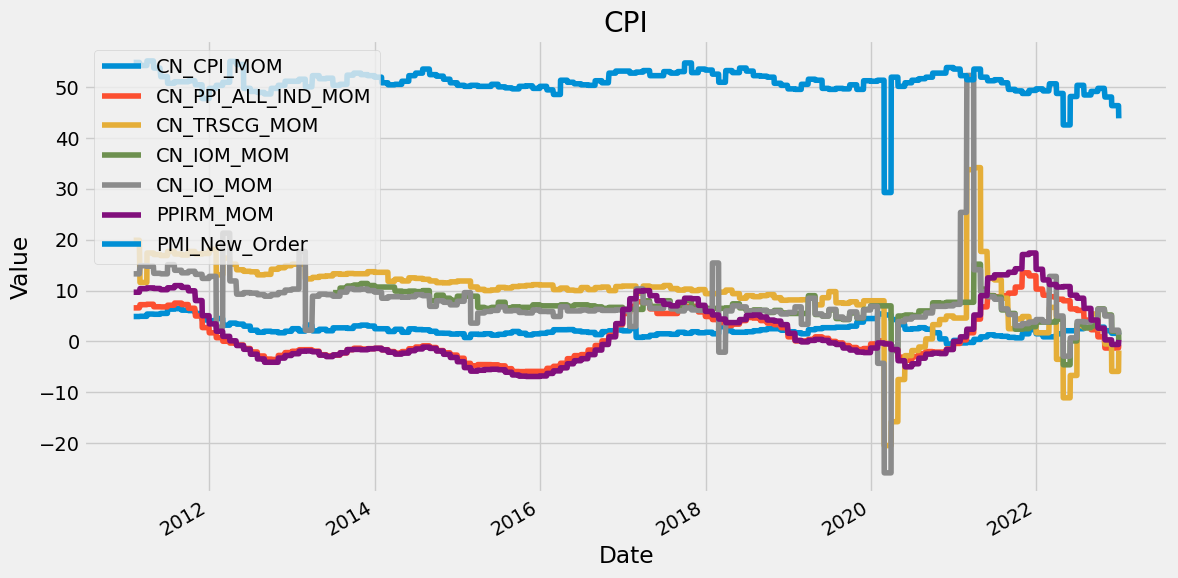

In [10]:
plot_features(cpi_df, ['CN_CPI_MOM', 'CN_PPI_ALL_IND_MOM', 'CN_TRSCG_MOM',
       'CN_IOM_MOM', 'CN_IO_MOM', 'PPIRM_MOM', 'PMI_New_Order'], title="CPI")

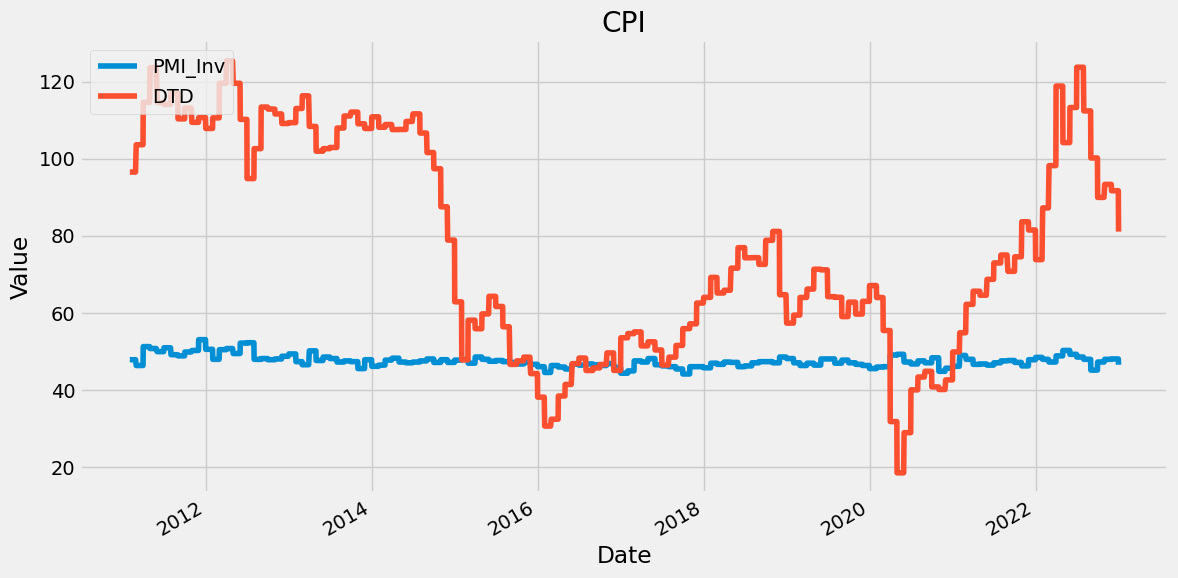

In [11]:
plot_features(cpi_df, ['PMI_Inv', 'DTD'], title="CPI")

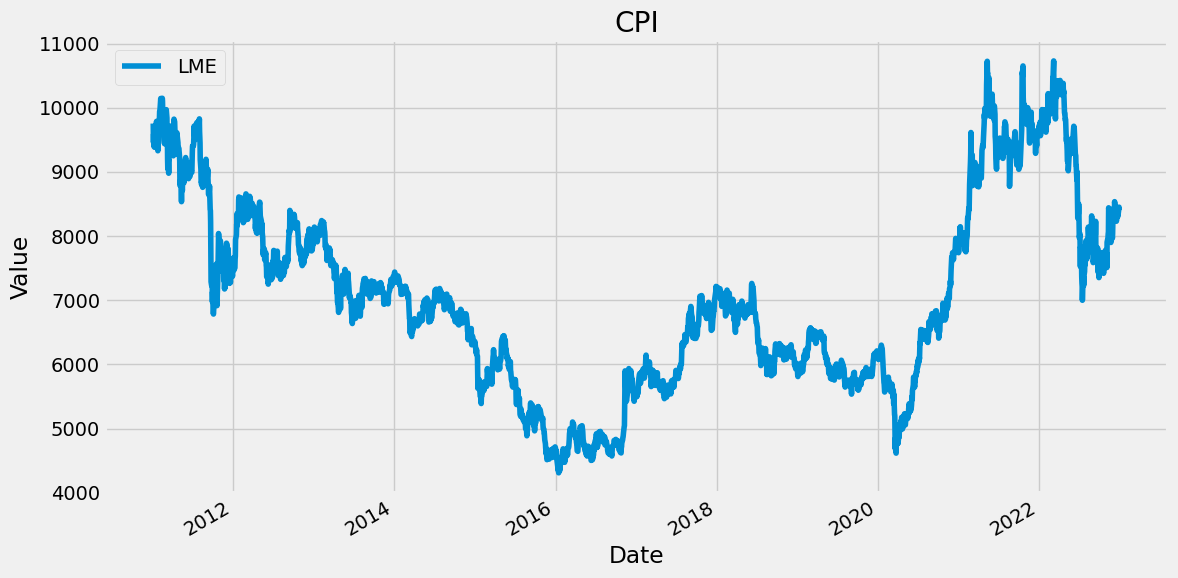

In [12]:
plot_features(cpi_df, ['LME'], title="CPI")

In [13]:
cpi_df.to_csv("./data/clean_features/features_inflation.csv", index=False, encoding="utf-8-sig")